# Bias and variance: some introductory examples

Disclaimer: this notebook was not written by us, so use as is. Our thanks go the the team of prof. Dambre.

## Noisy sine wave data set

We use the case of polynomial regression where we approximate noisy data sampled from one period of a sine wave.

The code below defines all the necessary functions and plots some example data.

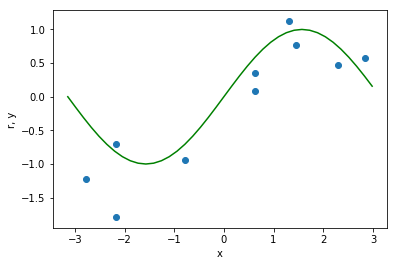

In [ ]:
import numpy as np
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import math

# seed random generator such that it always returns the same random values 
# (for reproducability of results)
rng = np.random.RandomState(42)

# Generate data from a single sine period 
# with gaussian noise added
def SineModel(n=10, epsilon = 5):
    x = math.pi*(rng.rand(n,1) * 2.0 - 1.0)
    r = np.sin(x) + rng.randn(n, 1)*epsilon   
    return x,r

# Apply normal form linear regression
def LinearRegression(x,r):
    X = np.hstack((x,np.ones((x.shape[0],1))))
    w = np.dot(np.dot(np.linalg.pinv(np.dot(X.T , X)), X.T), r)
    y = np.dot(X, w)
    return w, y

def PolynomialFeatureMatrix(data = [], degree = 2):
    n=data.shape[0]
    X = data
    for j in range(1,degree):
        X = np.hstack((X,data**(j+1))) 
    return X 

# Compute total MSE for linear model and given weight values [w_0, w_1]
def total_cost_mse(x, r , w):
    X = np.hstack((x,np.ones((x.shape[0],1))))
    err = np.dot(X, w) - r
    mse = np.dot(err.T,err)/x.shape[0]
    return mse

# parameters
n = 10
epsilon = 0.5

# Generate data points
x,r = SineModel(n=n, epsilon = epsilon)

# plot data
x_ground = math.pi*np.arange(-1.0,1.0,0.05)
ground_truth = np.sin(x_ground)

plt.figure()
plt.scatter(x, r)
plt.plot(x_ground,ground_truth,color = 'g')
plt.xlabel("x")
plt.ylabel("r, y")
plt.show()

## Bias and variance theory

The theoretical concepts of model bias and model variance address the expected mean and variance across hypotheses trained on all possible same size sets of training data which could be sampled from the world. Clearly, these averages cannot be computed in real life. 

We know from theory that the expected MSE on unseen data equals the sum of squared bias and variance. If the ground truth is deterministic and a model is capable of perfectly approximating it (assuming no irreducible noise on the data sampled from that distribution), the bias and variance are equal to zero. If, however, there is noise on the data that can not be predicted, the bias can still be zero, but the variance equals the variance on the noise. Hence, the latter is a lower bound on the MSE and this is why we call it irreducible noise. 

In practice, the model can be underfitting, which means it is not sufficiently powerful to explain even the predictable part of the ground truth. This will lead to increased bias. When not enough training data is used in relation to the model complexity, the final hypothesis will be sensitive to the specific training samples that are used. This increases the variance.

After training a model, it is important to know how best to further improve it. In other words, to try and investigate where the remaining MSE comes from. Since bias and variance are coupled through MSE, they can not be measured separately. And actually, even the expected MSE can only be estimated, since only a finite set of unseen data samples is available. Therefore, approximations need to be made to try and diagnose the weaknesses of a machine learning model. 


## Hypothesis variability

To allow you to explore the variability of a model as a function of the data set size, we generate a single large validation set of equally spaced samples on which we validate a number of hypotheses, each trained on a different random training set. We plot the solutions in data space and compute the MSE on the noiseless ground truth and on noisy data sampled from the same distribution as the training data. 

Play around with the parameters such as polynomial degree, epsilon and the number of training samples to see how the variability of the fitted curves and the variance accross the trained models change. Make sure that you understand what happens for very large training sets.

Also, you can try to use the ridge regression model instead of the unregularised model to see how that changes things.

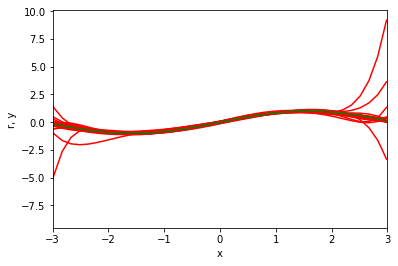

MSE average on validation data:  0.4670484450258806 , variance on MSE:  1.3746273246926728


In [ ]:
# parameters
# number of training samples
n = 20

# Stdev of zero-mean noise on the data
epsilon = 0.1

# number of hypotheses trained on different sets of training samples
num_iterations = 20

# degree of polynomial model
poly_order = 7

# number of validation samples
validation_set_size = 200000

# compute validation samples, equally spaced accross interval
# this is used to plot the curves below
x_ground = np.array(math.pi*np.arange(-1.0,1.0,0.05))
x_ground = x_ground.reshape(-1,1)
r_ground = np.sin(x_ground)
X_ground = PolynomialFeatureMatrix(data = x_ground, degree = poly_order)
X_plt = np.hstack((X_ground,np.ones((X_ground.shape[0],1))))    

plt.figure()
plt.xlabel("x")
plt.ylabel("r, y")

mse_vals = np.zeros(num_iterations)
x_val,r_val = SineModel(n=validation_set_size, epsilon = epsilon)
X_val = PolynomialFeatureMatrix(data = x_val, degree = poly_order)


for idx in range(num_iterations):
    # Generate data points
    x,r = SineModel(n=n, epsilon = epsilon)
    # Generate polynomial feature matrix
    X = PolynomialFeatureMatrix(data = x, degree = poly_order)
    # Perform linear regression
    w,y = LinearRegression(X,r)
    # Calculate hypothesis for visualisation
    y_plt = np.dot(X_plt,w)
    plt.plot(x_ground,y_plt,color = 'r')
    plt.xlim([-3,3])
    mse_vals[idx] = total_cost_mse(X_val, r_val , w)

plt.plot(x_ground,r_ground,color = 'g')
plt.show()

avg_mse = np.mean(mse_vals)
var_mse = np.var(mse_vals)


# note that the variance on the MSE, plotted below, is NOT the model variance!
print("MSE average on validation data: ",avg_mse,", variance on MSE: ",var_mse)


You should see that increasing the number of training samples decreases the variability accross models, while increasing the polynomial order increases it. They both increase/decrease with the noise on the data.

## Using learning curves to get an idea

In the linear regression tutorial, we introduced learning curves. We saw that these can be used to estimate to which value MSE would converge IF we could get enough data. Although you may not be able to get to this convergence point, you know it will be somewhere between the training MSE and the validation MSE obtained at the far right of your learning curve. 

From the theory outlined above, this limit eliminates the portion of the expected MSE that is caused by model variability, leaving only the model bias and the contribution of the variance of the noise on the data. Unfortunately, these can not be separated, but you can get an estimate of the model variance from the distance your hypothesis is away from this limit. Always be aware of the fact that this still remains an estimate, because of the limited set of unseen data used for estimating the generalisation MSE!

Since calculating learning curves takes a lot of computing time, a validation strategy that averages accross a number of hypotheses, trained on different subsets of the data, can at least give a hint. If there is a lot of variance on the validation MSE estimates, this can be due to model variance, variance due to having a small validation set or data noise.

The code below uses the learning curves of the linear regression tutorial on the unregularised models used in this notebook. Again, please feel free to introduce regularisation and study its impact by changing the code.

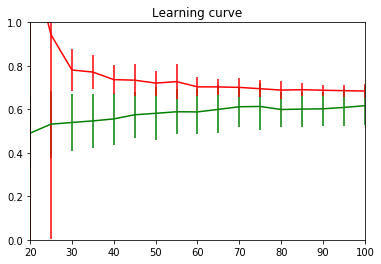

In [ ]:
def cost_mse(y,y_hat):
    
    mse = np.mean((y - y_hat)**2)
    
    return mse

# degree of polynomial model
poly_order = 4

# Generate 1000 train samples 
# Make random selections of 5, 10,..., 100 train samples 
# and 1000 validation samples
# Repeat this a number of times for each number of train samples 
# and keep both the train and the test MSE

max_train_samples = 100
train_samples = np.arange(start=5,stop=max_train_samples+1,step=5)
validation_samples = 1000
total_samples = max_train_samples + validation_samples
iterations = 100

# compute validation samples, equally spaced accross interval
# this is used to plot the curves below
x_ground = np.array(math.pi*np.arange(-1.0,1.0,0.05))
x_ground = x_ground.reshape(-1,1)
r_ground = np.sin(x_ground)
X_ground = PolynomialFeatureMatrix(data = x_ground, degree = poly_order)
X_plt = np.hstack((X_ground,np.ones((X_ground.shape[0],1))))    

# Stdev of zero-mean noise on the data
epsilon = 0.8

train_errors = np.zeros((len(train_samples),iterations))
validation_errors = np.zeros((len(train_samples),iterations))

x_data,y_data = SineModel(n=total_samples, epsilon = epsilon)

for ids in range(len(train_samples)):
    s = train_samples[ids]
    for idt in range(iterations):
        perm = np.random.permutation(total_samples)
        x_train = x_data[perm[:s]]
        X_train = PolynomialFeatureMatrix(data = x_train, degree = poly_order)
        y_train = y_data[perm[:s]]
        x_validation = x_data[perm[s:s+validation_samples]]
        X_validation = PolynomialFeatureMatrix(data = x_validation, degree = poly_order)
        X_validation = np.hstack((X_validation,np.ones((X_validation.shape[0],1))))    
        y_validation = y_data[perm[s:s+validation_samples]]
        
        W, y_hat_train = LinearRegression(X_train,y_train)
        train_errors[ids,idt] = cost_mse(y_train, y_hat_train)
        
        y_hat_validation = np.dot(X_validation, W)
        validation_errors[ids,idt] = cost_mse(y_validation, y_hat_validation)
        
train_mean = np.mean(train_errors, axis = 1)        
validation_mean = np.mean(validation_errors, axis = 1)        
train_std = np.std(train_errors, axis = 1)        
validation_std = np.std(validation_errors, axis = 1)        

plt.figure()
plt.errorbar(train_samples, train_mean, yerr=train_std, color = 'g', ecolor = 'g')
plt.errorbar(train_samples, validation_mean, yerr=validation_std, color = 'r', 
             ecolor = 'r')
plt.xlim([20.0,100.0])
plt.ylim([0.0,1.0])
plt.title("Learning curve")
plt.show()

In [ ]:
#This code snippet ensures that the notebook uses the custom.css style sheet

from IPython.core.display import HTML
def css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()